In [ ]:
# Instal dependencies
%pip install ipykernel
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install tensorflow
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import gc
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

2025-04-15 14:47:37.739690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 14:47:37.765619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744708657.796168  770114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744708657.805603  770114 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744708657.828583  770114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# Load  data & normalise it
def load_data(class_list, samples_per_class=20000):
    X, y = [], []

    for class_idx, class_name in enumerate(class_list):
        try:
            data = np.load(f"/data/yuvrajpr24/quickdraw-cnn/data/{class_name}.npy")[
                :samples_per_class
            ]
            X.append(data.reshape(-1, 28, 28, 1))
            y.append(np.full(data.shape[0], class_idx))
        except FileNotFoundError:
            print(f"file missing {class_name}.npy")
            continue

    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)

    X = X.astype("float32") / 255.0

    return X, y

In [ ]:
# split the data in 80 10 10 
def split_data(X, y, test_size=0.1, val_size=0.1, random_state=42):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=random_state
    )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [ ]:
# base model is in dfault arguments & for ablation we can pass updated arguments
def build_cnn(
    input_shape=(28, 28, 1),
    num_classes=345,
    conv_layers=[
        (32, 3, tf.keras.layers.BatchNormalization()),
        (64, 3, tf.keras.layers.BatchNormalization()),
    ],
    dense_layers=[128],
    dropout_rate=0.4,
):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))

    for filters, kernel_size, normalization in conv_layers:
        model.add(tf.keras.layers.Conv2D(filters, kernel_size, activation="relu"))
        model.add(tf.keras.layers.MaxPooling2D(2))
        model.add(normalization)

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(dropout_rate))

    for units in dense_layers:
        model.add(tf.keras.layers.Dense(units, activation="relu"))
        model.add(tf.keras.layers.Dropout(dropout_rate / 2))

    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    return model

In [ ]:
# Here I can update some cofnigurations so that code runes effectively on GPU
def configure_gpu():
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

    # Enable XLA compilation, accelerated linear algbera
    tf.config.optimizer.set_jit(True)

    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

In [ ]:
# Diffreent plots for individual models
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=history.epoch, y=history.history["loss"], label="Train Loss")
    sns.lineplot(x=history.epoch, y=history.history["val_loss"], label="Val Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=history.epoch, y=history.history["accuracy"], label="Train Accuracy")
    sns.lineplot(
        x=history.epoch, y=history.history["val_accuracy"], label="Val Accuracy"
    )
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}/training_history.png")
    plt.show()


def plot_sample_images(X, y, class_list, model_name, n=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(X), n, replace=False)

    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[indices[i]].squeeze(), cmap="gray")
        plt.title(class_list[y[indices[i]]], fontsize=8)
        plt.axis("off")

    plt.suptitle("Sample Training Images", y=0.92)
    plt.savefig(f"{model_name}/sample_images.png")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_list, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 12))
    sns.heatmap(
        cm_norm,
        annot=False,
        cmap="Blues",
        xticklabels=class_list,
        yticklabels=class_list,
    )
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=90, ha="right", fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.savefig(f"{model_name}/confusion_matrix.png")
    plt.show()

In [ ]:
# different plots for abation study visualizration
def plot_ablation_comparison(ablation_results):
    plt.figure(figsize=(15, 6))

    # accuracy Comparison
    plt.subplot(1, 2, 1)
    for model_name, results in ablation_results.items():
        sns.lineplot(x=results["epochs"], y=results["val_accuracy"], label=model_name)
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1, 1))

    # Loss xomparison
    plt.subplot(1, 2, 2)
    for model_name, results in ablation_results.items():
        sns.lineplot(x=results["epochs"], y=results["val_loss"], label=model_name)
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.savefig("ablation_comparison.png")
    plt.show()


def plot_metric_barchart(ablation_results):
    metrics = {
        model_name: {
            "val_accuracy": max(res["val_accuracy"]),
            "train_time": res["train_time"],
            "test_accuracy": res["test_accuracy"],
        }
        for model_name, res in ablation_results.items()
    }

    df = pd.DataFrame(metrics).T
    df = df.sort_values("test_accuracy", ascending=False)

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=df.index, y=df["test_accuracy"])
    plt.title("Test Accuracy Comparison")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Accuracy")

    # Add annotations
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.3f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )

    plt.tight_layout()
    plt.savefig("ablation_accuracy.png")
    plt.show()


def plot_training_time_comparison(ablation_results):
    times = {
        model_name: res["train_time"] for model_name, res in ablation_results.items()
    }
    df = pd.DataFrame.from_dict(times, orient="index", columns=["Time"])

    plt.figure(figsize=(10, 6))
    sns.barplot(x=df.index, y=df["Time"])
    plt.title("Training Time per Epoch Comparison")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.savefig("ablation_training_time.png")
    plt.show()


def plot_learning_curves(ablation_results):
    plt.figure(figsize=(15, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for model_name, res in ablation_results.items():
        plt.plot(res["epochs"], res["val_accuracy"], label=model_name)
    plt.title("Validation Accuracy Trajectories")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for model_name, res in ablation_results.items():
        plt.plot(res["epochs"], res["val_loss"], label=model_name)
    plt.title("Validation Loss Trajectories")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig("learning_curves.png")
    plt.show()


def plot_parameter_efficiency(ablation_results):
    df = pd.DataFrame(
        [
            {
                "Parameters": res["parameters"],
                "Test Accuracy": res["test_accuracy"],
                "Model": model_name,
            }
            for model_name, res in ablation_results.items()
        ]
    )

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="Parameters", y="Test Accuracy", hue="Model", s=200)
    plt.title("Model Efficiency: Parameters vs Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("parameter_efficiency.png")
    plt.show()

In [ ]:

configure_gpu()

In [ ]:

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:

batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1744708678.469350  770114 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8388 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


## Training with ablation study

In [13]:
ablation_results = {}

ablation_params = [
    ("base", {}),
    ("No Dropout", {"dropout_rate": 0}),
    (
        "Deeper Conv Layers + Wider Dense",
        {
            "conv_layers": [
                (64, 5, tf.keras.layers.BatchNormalization()),
                (128, 3, tf.keras.layers.BatchNormalization()),
            ],
            "dense_layers": [256],
        },
    ),
]

In [ ]:
for model_name, params in ablation_params:
    print(f"Training model: {model_name}")

    model = build_cnn(**params)

    os.makedirs(model_name, exist_ok=True)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )


    start_time = time.time()
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(
                f"{model_name}/best_model.keras", save_best_only=True
            ),
            tf.keras.callbacks.TensorBoard(log_dir="./logs"),
        ],
    )
    train_time = (time.time() - start_time)


    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    ablation_results[model_name] = {
        "train_accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
        "train_loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "test_accuracy": test_acc,
        "train_time": train_time / len(history.epoch),  # Per epoch time
        "params": params,
        "epochs": history.epoch,
        "parameters": model.count_params(),
    }


    y_pred = model.predict(X_test).argmax(axis=1)


    plot_training_history(history, model_name)


    plot_confusion_matrix(y_test, y_pred, class_list, model_name)

    del model
    gc.collect()

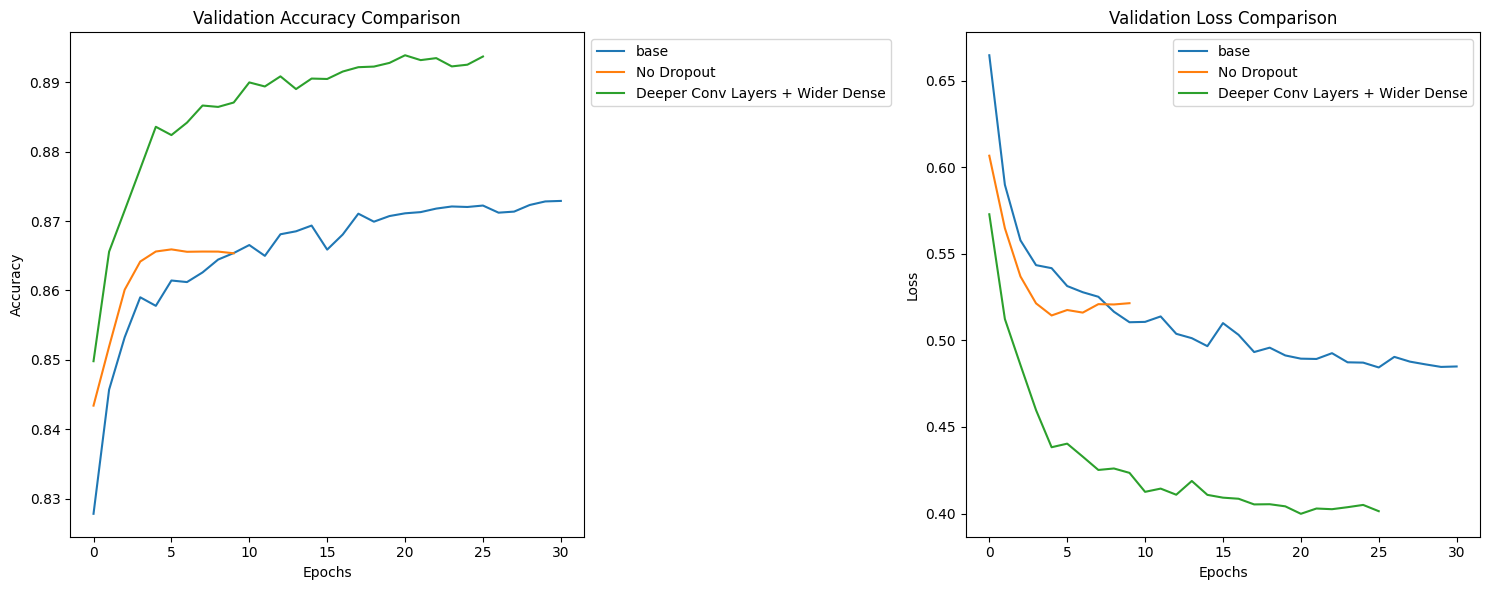

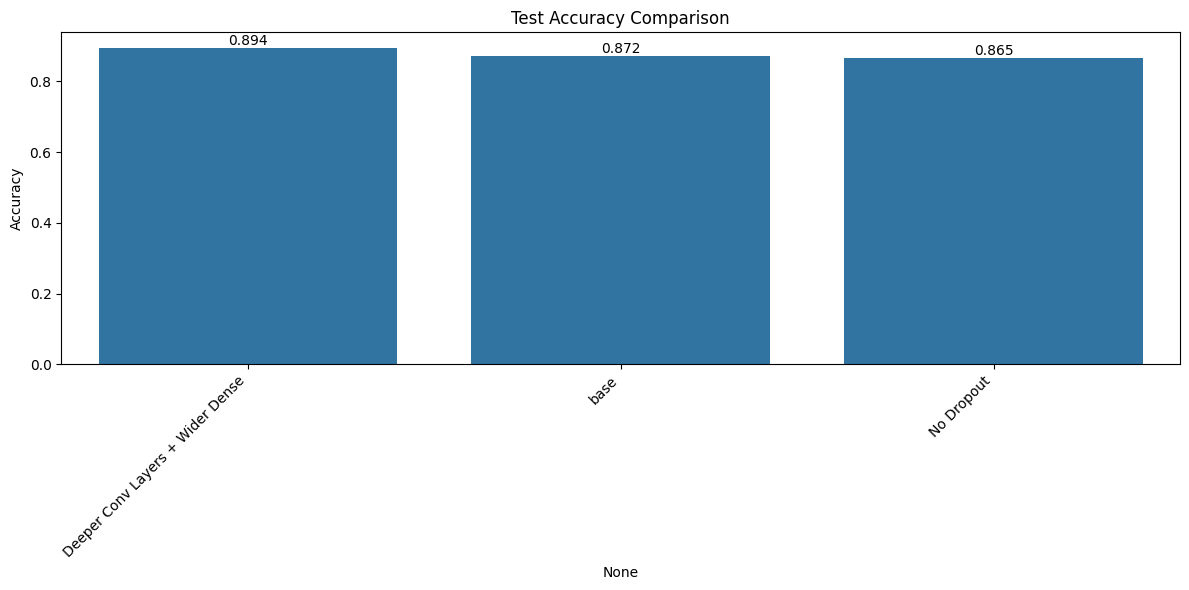

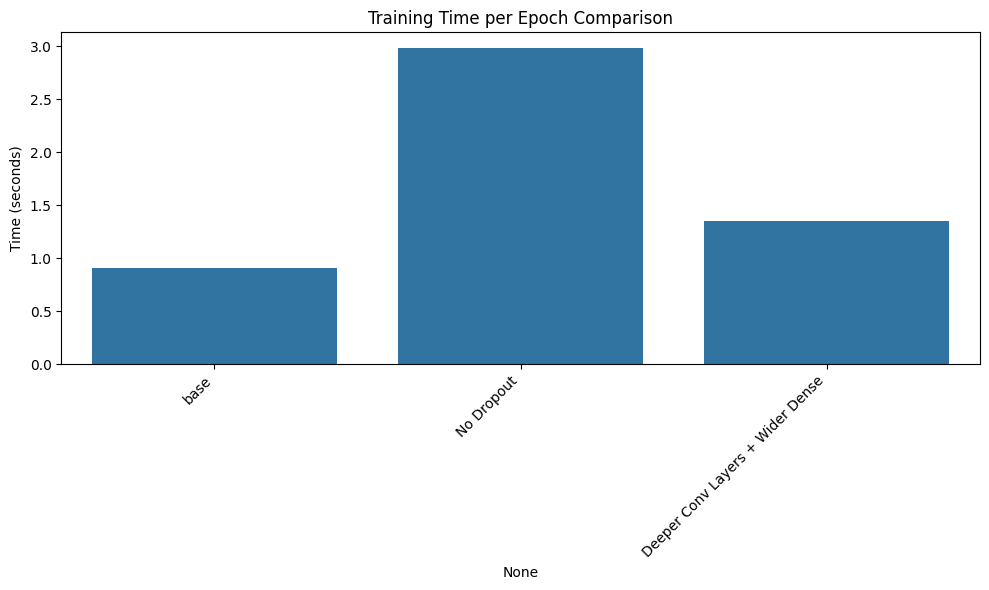

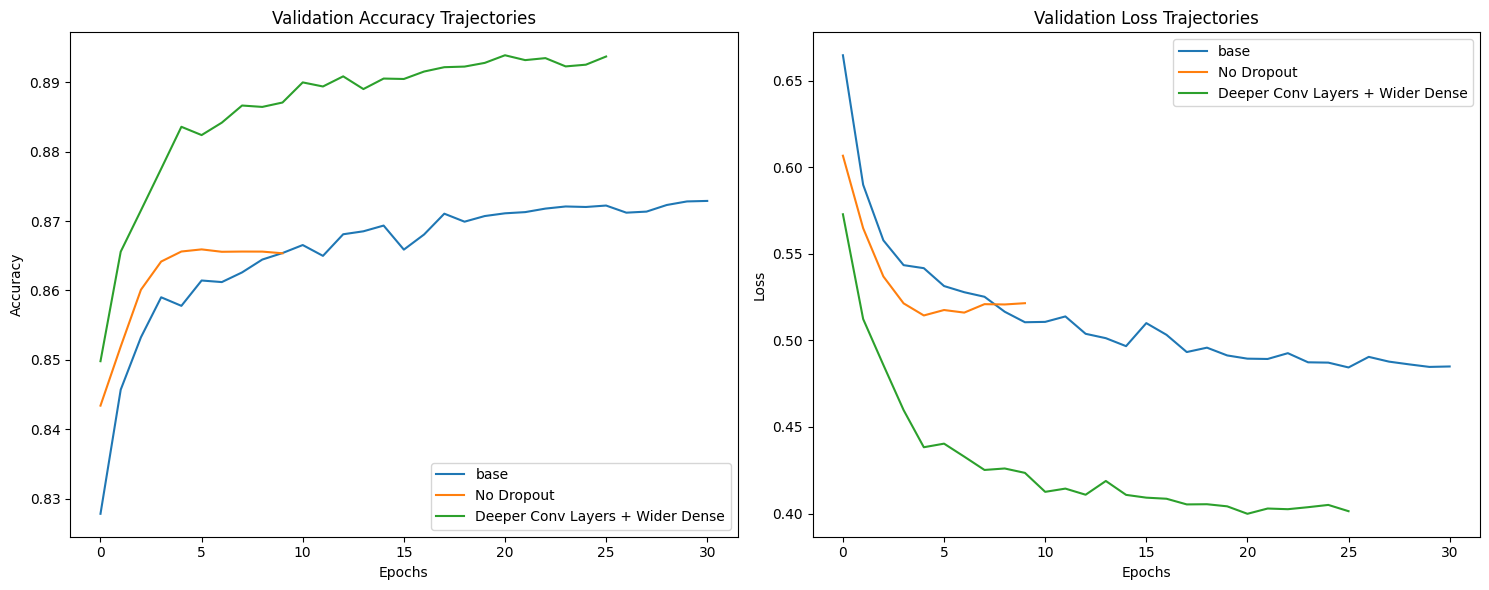

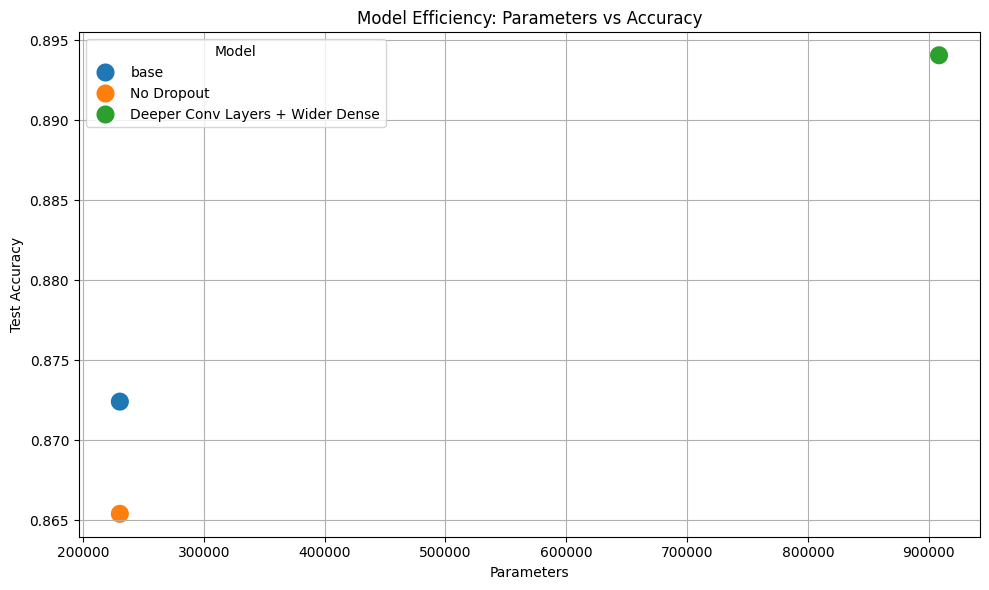

In [38]:
# Step 10: Visualize comparative analysis
plot_ablation_comparison(ablation_results)
plot_metric_barchart(ablation_results)
plot_training_time_comparison(ablation_results)
plot_learning_curves(ablation_results)
plot_parameter_efficiency(ablation_results)